In [1]:
import pandas,os,importlib,numpy

import matplotlib,matplotlib.pyplot
import scipy,scipy.stats
import miner_20190520 as miner

matplotlib.pyplot.rcParams['axes.axisbelow'] = True
matplotlib.rcParams.update({'font.size':18,'font.family':'Arial','xtick.labelsize':20,'ytick.labelsize':20,'axes.labelsize':30})
matplotlib.rcParams['pdf.fonttype']=42

In [2]:
patient=['amp1q','t414','del13'] # plus trisomy 5, not found in MMRF. Trisomy 5 is better prognosis on t4;14 patients

# 1. Read cytogenetics

In [3]:
cytogenetics_file='/Users/alomana/Google Drive File Stream/My Drive/projects/MINER/shared/MINER/data/mutations/cytogenetics.csv'

In [33]:
cytogenetics_file='/Users/adrianlopezgarciadelomana/gd/projects/MINER/shared/MINER/data/mutations/cytogenetics.csv'
calls_file='/Users/adrianlopezgarciadelomana/gd/projects/MINER/shared/MINER/data/mutations/translocationsIA12.csv'

In [5]:
df=pandas.read_csv(cytogenetics_file,index_col=0)
df

,MMRF_1017_1_BM,MMRF_1024_1_BM,MMRF_1024_3_BM,MMRF_1038_1_BM,MMRF_1033_1_BM,MMRF_1007_1_BM,MMRF_1052_1_BM,MMRF_1082_1_BM,MMRF_1094_1_BM,MMRF_1093_1_BM,...,MMRF_2836_1_BM,MMRF_2838_1_BM,MMRF_2839_1_BM,MMRF_2840_1_BM,MMRF_2843_1_BM,MMRF_2846_1_BM,MMRF_2847_1_BM,MMRF_2848_1_BM,MMRF_2851_1_BM,MMRF_2853_1_BM
del13,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,1,0
del17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
t414,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
t1114,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
t1416,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
del17p,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
del1p,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
amp1q,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,1,1


In [35]:
calls=pandas.read_csv(calls_file,index_col=0)
calls

,MMRF_1439_1_BM,MMRF_2778_1_BM,MMRF_2795_1_BM,MMRF_1137_3_BM,MMRF_1949_1_BM,MMRF_2384_1_BM,MMRF_1108_1_BM,MMRF_1988_1_BM,MMRF_1364_1_BM,MMRF_2554_1_BM,...,MMRF_1031_1_BM,MMRF_2194_1_BM,MMRF_2173_1_BM,MMRF_2352_1_BM,MMRF_2013_1_BM,MMRF_1766_1_BM,MMRF_1998_1_BM,MMRF_1462_3_BM,MMRF_1331_1_BM,MMRF_2613_1_BM
RNASeq_CCND1_Call,1,0,0,1,0,1,0,0,0,0,...,0,1,1,1,0,0,1,0,0,0
RNASeq_CCND2_Call,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RNASeq_CCND3_Call,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RNASeq_FGFR3_Call,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RNASeq_MAFA_Call,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RNASeq_MAFB_Call,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RNASeq_MAF_Call,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RNASeq_MYC_Call,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RNASeq_WHSC1_Call,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# 2. Find similar patients

In [36]:
dft=df.T
callsT=calls.T

In [7]:
#! make sure I clean for available rnaseq calls too.
similar=dft[
    (dft['amp1q'] == 1) & # 
    (dft['t414'] == 1) &  # whc1 
    (dft['del13'] == 1) & # 
    #
    (dft['del17'] == 0) & 
    (dft['t1114'] == 0) & # ccnd1
    (dft['t1416'] == 0) & # maf
    (dft['del17p'] == 0) & #
    (dft['del1p'] == 0)
]
print(similar.shape)
similar

(21, 8)


,del13,del17,t414,t1114,t1416,del17p,del1p,amp1q
MMRF_1433_1_BM,1,0,1,0,0,0,0,1
MMRF_1783_2_BM,1,0,1,0,0,0,0,1
MMRF_1974_1_BM,1,0,1,0,0,0,0,1
MMRF_2101_1_BM,1,0,1,0,0,0,0,1
MMRF_2621_1_BM,1,0,1,0,0,0,0,1
MMRF_2477_1_BM,1,0,1,0,0,0,0,1
MMRF_1300_1_BM,1,0,1,0,0,0,0,1
MMRF_1109_1_BM,1,0,1,0,0,0,0,1
MMRF_2297_1_BM,1,0,1,0,0,0,0,1
MMRF_2253_1_BM,1,0,1,0,0,0,0,1


In [50]:
callsT.head()
a=similar.index.tolist()
b=['RNASeq_WHSC1_Call','RNASeq_CCND1_Call','RNASeq_MAF_Call']
callsT.loc[a][b]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


,RNASeq_WHSC1_Call,RNASeq_CCND1_Call,RNASeq_MAF_Call
MMRF_1433_1_BM,1.0,0.0,0.0
MMRF_1783_2_BM,1.0,0.0,0.0
MMRF_1974_1_BM,1.0,0.0,1.0
MMRF_2101_1_BM,NaN,NaN,NaN
MMRF_2621_1_BM,1.0,0.0,0.0
MMRF_2477_1_BM,NaN,NaN,NaN
MMRF_1300_1_BM,1.0,0.0,0.0
MMRF_1109_1_BM,NaN,NaN,NaN
MMRF_2297_1_BM,1.0,0.0,0.0
MMRF_2253_1_BM,1.0,0.0,0.0


# 3. Map patients to relapse networks

## 3.0. Info paths

In [8]:
expression_data_file='/Users/alomana/Google Drive File Stream/My Drive/projects/MINER/shared/MINER/data/expression/IA12Zscore.csv'
regulonDf_file='/Users/alomana/Google Drive File Stream/My Drive/projects/MINER/shared/MINER/results_minCorrelation_0o2_50_allFiles/regulonDf.csv'
overExpressedMembersMatrix_file='/Users/alomana/Google Drive File Stream/My Drive/projects/MINER/shared/MINER/results_minCorrelation_0o2_50_allFiles/overExpressedMembers.csv'

In [9]:
expression_data_file='/Users/adrianlopezgarciadelomana/gd/projects/MINER/shared/MINER/data/expression/IA12Zscore.csv'
regulonDf_file='/Users/adrianlopezgarciadelomana/gd/projects/MINER/shared/MINER/results_minCorrelation_0o2_50_allFiles/regulonDf.csv'
overExpressedMembersMatrix_file='/Users/adrianlopezgarciadelomana/gd/projects/MINER/shared/MINER/results_minCorrelation_0o2_50_allFiles/overExpressedMembers.csv'

## 3.1. Read data

In [10]:
expressionData, conversionTable = miner.preprocess(expression_data_file)

completed identifier conversion.
16216 genes were converted.


In [11]:
regulonDf = pandas.read_csv(regulonDf_file,index_col=0,header=0)

In [12]:
overExpressedMembersMatrix = pandas.read_csv(overExpressedMembersMatrix_file,index_col=0,header=0)

# explore relapse MMRF

In [13]:
target_labels=similar.index.tolist()
target_ids=[element.split('_')[1] for element in target_labels]

matches=[]
mmrf_labels=expressionData.columns
for element in mmrf_labels:
    reference=element.split('_')[1]
    if reference in target_ids:
        matches.append(element)
matches.sort()
print(matches)

['MMRF_1300_1_BM', 'MMRF_1433_1_BM', 'MMRF_1433_2_BM', 'MMRF_1433_4_BM', 'MMRF_1783_1_BM', 'MMRF_1783_2_BM', 'MMRF_1974_1_BM', 'MMRF_2253_1_BM', 'MMRF_2297_1_BM', 'MMRF_2604_1_BM', 'MMRF_2621_1_BM', 'MMRF_2621_1_PB', 'MMRF_2626_1_BM', 'MMRF_2636_1_BM', 'MMRF_2682_1_BM', 'MMRF_2694_1_BM', 'MMRF_2706_1_BM', 'MMRF_2719_1_BM', 'MMRF_2767_1_BM', 'MMRF_2815_1_BM']


## 3.2 Find relapse signatures using all baseline

In [14]:
# Define phenotypes of interest
all_patients = expressionData.columns
baseline_patients = [pat for pat in all_patients if pat.split("_")[2]=='1']
first_relapse_patients = [pat for pat in all_patients if pat.split("_")[2]=='2']
relapse_patients = [pat for pat in all_patients if pat.split("_")[2]!='1']
multiple_relapse_patients = list(set(relapse_patients)-set(first_relapse_patients))

phenotype1 = baseline_patients
phenotype2 = relapse_patients

print(len(phenotype1))
print(len(phenotype2))

print(phenotype2[:10])

779
102
['MMRF_1518_3_BM', 'MMRF_1650_2_BM', 'MMRF_1433_4_BM', 'MMRF_1931_2_BM', 'MMRF_2373_2_BM', 'MMRF_1686_2_BM', 'MMRF_1284_2_BM', 'MMRF_1229_3_BM', 'MMRF_2089_3_BM', 'MMRF_1500_2_BM']


completed in 4.88 minutes


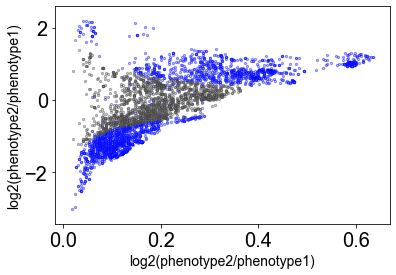

In [15]:
#importlib.reload(miner)
volcano_data = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = 3,minRegulons = 3,useAllRegulons = False,savefile = 'figure.pdf')

In [16]:
volcano_data.head()

,phenotype1_frequency,phenotype2_frequency,log2(phenotype2/phenotype1),-log10(p)
ENSG00000162704,0.243261,0.598039,1.297737,13.169983
ENSG00000076003,0.253209,0.610294,1.269175,13.122465
ENSG00000119403,0.251926,0.607843,1.270702,13.082748
ENSG00000117632,0.240051,0.590686,1.299049,12.971055
ENSG00000087586,0.261874,0.617647,1.237909,12.840049


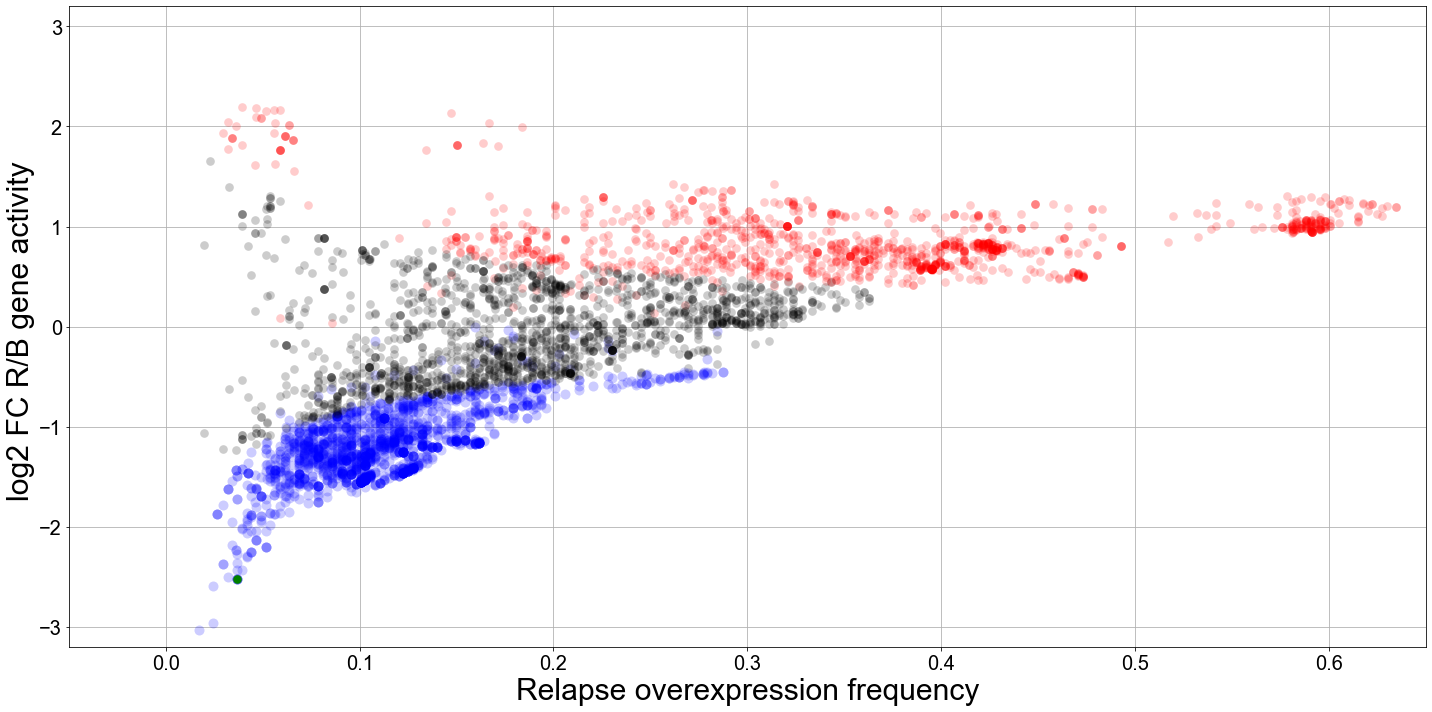

In [17]:
ikzf1 = "ENSG00000185811"

insigvoldata_patients = volcano_data.index[volcano_data["-log10(p)"]<=-numpy.log10(0.05)]
sigvoldata_patients_plus = volcano_data.index[(volcano_data["-log10(p)"] > -numpy.log10(0.05)) & (volcano_data['log2(phenotype2/phenotype1)'] > 0)]
sigvoldata_patients_minus = volcano_data.index[(volcano_data["-log10(p)"] > -numpy.log10(0.05)) & (volcano_data['log2(phenotype2/phenotype1)'] < 0)]

insigvoldata = volcano_data.loc[insigvoldata_patients,:]
sigvoldata_plus = volcano_data.loc[sigvoldata_patients_plus,:]
sigvoldata_minus = volcano_data.loc[sigvoldata_patients_minus,:]

fig = matplotlib.pyplot.figure(figsize=(20,10))

matplotlib.pyplot.scatter(sigvoldata_plus["phenotype2_frequency"],numpy.array(sigvoldata_plus["log2(phenotype2/phenotype1)"]),color = 'red',alpha=0.2,s=75,linewidths=0)

matplotlib.pyplot.scatter(sigvoldata_minus["phenotype2_frequency"],numpy.array(sigvoldata_minus["log2(phenotype2/phenotype1)"]),color = 'blue',alpha=0.2,s=100,linewidths=0)

matplotlib.pyplot.scatter(insigvoldata["phenotype2_frequency"],numpy.array(insigvoldata["log2(phenotype2/phenotype1)"]),color ='black',edgecolor = [0.1,0.1,0.1],alpha=0.2,s=75,linewidths=0)

matplotlib.pyplot.scatter(volcano_data.loc[ikzf1,"phenotype2_frequency"],numpy.array(volcano_data.loc[ikzf1,"log2(phenotype2/phenotype1)"]),color = 'green',s=75,linewidths=0)

matplotlib.pyplot.xlim(-0.05,0.65)
matplotlib.pyplot.ylim(-3.2,3.2)
matplotlib.pyplot.ylabel("log2 FC R/B gene activity ")
matplotlib.pyplot.xlabel("Relapse overexpression frequency")
matplotlib.pyplot.grid()
matplotlib.pyplot.tight_layout()

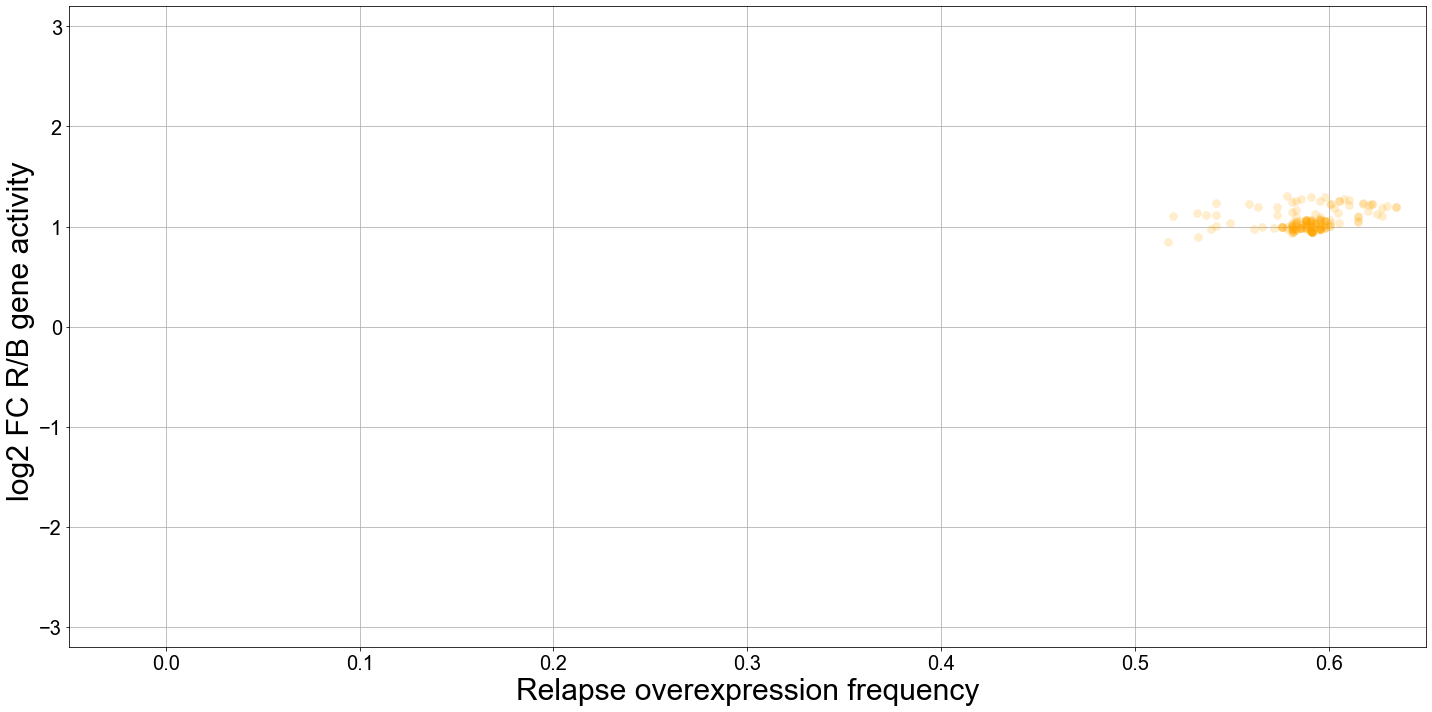

In [18]:
subset_patients = volcano_data.index[(volcano_data["-log10(p)"] > -numpy.log10(0.05)) & (volcano_data['log2(phenotype2/phenotype1)'] > 0.5) & (volcano_data['phenotype2_frequency'] > 0.5)]

subset_data = volcano_data.loc[subset_patients,:]

fig = matplotlib.pyplot.figure(figsize=(20,10))

matplotlib.pyplot.scatter(subset_data["phenotype2_frequency"],numpy.array(subset_data["log2(phenotype2/phenotype1)"]),color = 'orange',alpha=0.2,s=75,linewidths=0)

matplotlib.pyplot.xlim(-0.05,0.65)
matplotlib.pyplot.ylim(-3.2,3.2)
matplotlib.pyplot.ylabel("log2 FC R/B gene activity ")
matplotlib.pyplot.xlabel("Relapse overexpression frequency")
matplotlib.pyplot.grid()
matplotlib.pyplot.tight_layout()

In [19]:
subset_data.to_csv(path_or_buf='case_1.csv')

## 3.3 Find relapse signatures using matched patients

In [20]:
print(len(all_patients))
a=[element for element in all_patients if 'BM' in element]
b=[element for element in all_patients if 'PB' in element]
print(len(a),len(b),len(a)+len(b))

881
864 17 881


In [21]:
relapse_events = [pat for pat in all_patients if pat.split("_")[2]!='1']
relapse_events.sort()

baseline_patients=[]; relapse_patients=[]

for event in relapse_events:
    label=event.split('_')[1]
    baseline_label='MMRF_{}_1_BM'.format(label)
    if baseline_label in all_patients:
        baseline_patients.append(baseline_label)
        if 'BM' in event:
            relapse_patients.append(event)
        
baseline_patients=list(set(baseline_patients))
relapse_patients=list(set(relapse_patients))

baseline_patients.sort()
relapse_patients.sort()

print(baseline_patients,len(baseline_patients))
print(relapse_patients,len(relapse_patients))

['MMRF_1024_1_BM', 'MMRF_1030_1_BM', 'MMRF_1079_1_BM', 'MMRF_1137_1_BM', 'MMRF_1157_1_BM', 'MMRF_1179_1_BM', 'MMRF_1201_1_BM', 'MMRF_1224_1_BM', 'MMRF_1229_1_BM', 'MMRF_1235_1_BM', 'MMRF_1242_1_BM', 'MMRF_1269_1_BM', 'MMRF_1284_1_BM', 'MMRF_1285_1_BM', 'MMRF_1293_1_BM', 'MMRF_1309_1_BM', 'MMRF_1380_1_BM', 'MMRF_1401_1_BM', 'MMRF_1433_1_BM', 'MMRF_1462_1_BM', 'MMRF_1496_1_BM', 'MMRF_1565_1_BM', 'MMRF_1587_1_BM', 'MMRF_1627_1_BM', 'MMRF_1639_1_BM', 'MMRF_1656_1_BM', 'MMRF_1659_1_BM', 'MMRF_1671_1_BM', 'MMRF_1686_1_BM', 'MMRF_1694_1_BM', 'MMRF_1700_1_BM', 'MMRF_1783_1_BM', 'MMRF_1790_1_BM', 'MMRF_1908_1_BM', 'MMRF_1931_1_BM', 'MMRF_1978_1_BM', 'MMRF_1992_1_BM', 'MMRF_2015_1_BM', 'MMRF_2017_1_BM', 'MMRF_2039_1_BM', 'MMRF_2059_1_BM', 'MMRF_2076_1_BM', 'MMRF_2083_1_BM', 'MMRF_2087_1_BM', 'MMRF_2089_1_BM', 'MMRF_2122_1_BM', 'MMRF_2126_1_BM', 'MMRF_2194_1_BM', 'MMRF_2373_1_BM', 'MMRF_2401_1_BM', 'MMRF_2419_1_BM', 'MMRF_2490_1_BM', 'MMRF_2523_1_BM', 'MMRF_2531_1_BM', 'MMRF_2562_1_BM', 'MMRF_257

In [22]:
phenotype1 = baseline_patients
phenotype2 = relapse_patients

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


completed in 4.52 minutes


,phenotype1_frequency,phenotype2_frequency,log2(phenotype2/phenotype1),-log10(p)
ENSG00000076003,0.275424,0.657143,1.254554,4.819988
ENSG00000162704,0.262712,0.642857,1.291017,4.803258
ENSG00000117632,0.266949,0.646429,1.275926,4.782724
ENSG00000119403,0.266949,0.646429,1.275926,4.782724
ENSG00000132646,0.279661,0.657143,1.232528,4.725488


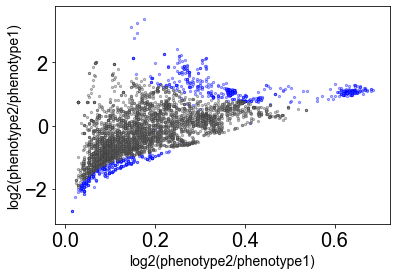

In [23]:
volcano_data = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = 3,minRegulons = 3,useAllRegulons = False)
volcano_data.head()

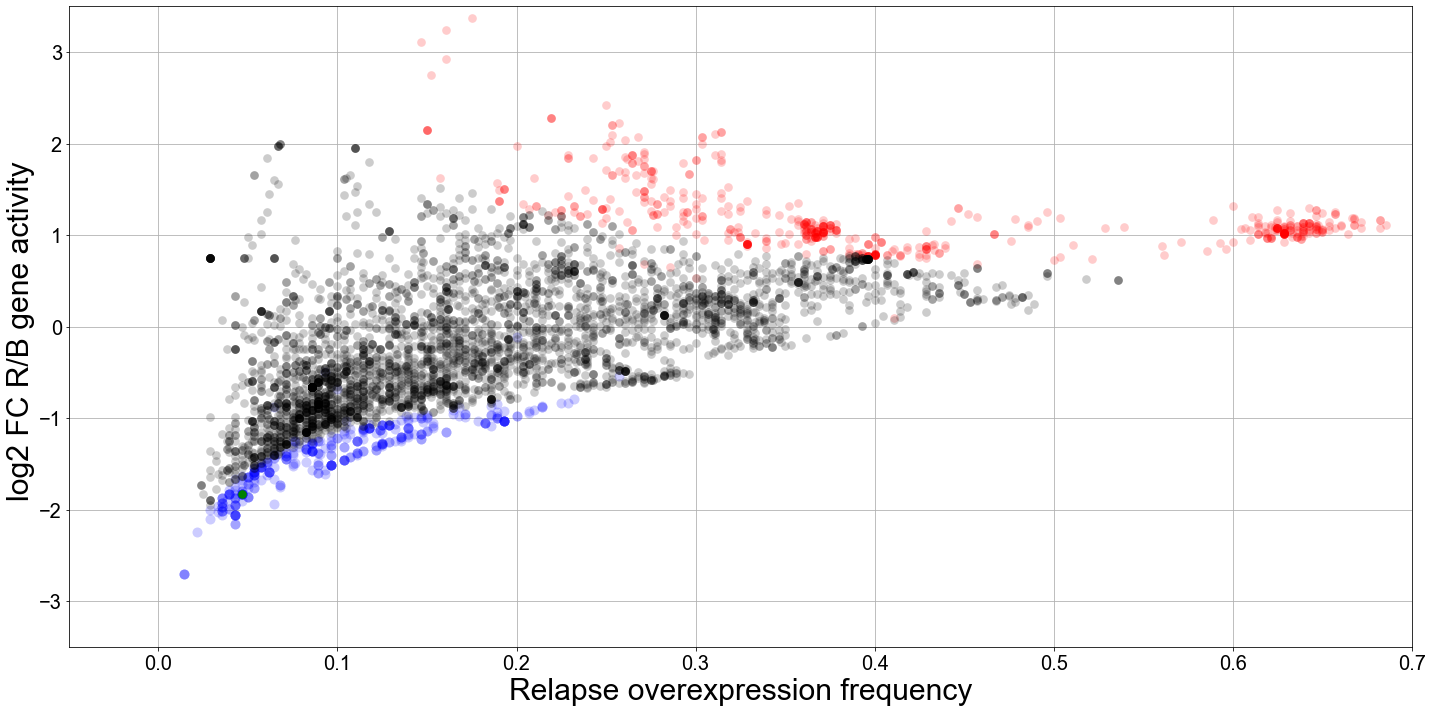

In [24]:
insigvoldata_patients = volcano_data.index[volcano_data["-log10(p)"]<=-numpy.log10(0.05)]
sigvoldata_patients_plus = volcano_data.index[(volcano_data["-log10(p)"] > -numpy.log10(0.05)) & (volcano_data['log2(phenotype2/phenotype1)'] > 0)]
sigvoldata_patients_minus = volcano_data.index[(volcano_data["-log10(p)"] > -numpy.log10(0.05)) & (volcano_data['log2(phenotype2/phenotype1)'] < 0)]

insigvoldata = volcano_data.loc[insigvoldata_patients,:]
sigvoldata_plus = volcano_data.loc[sigvoldata_patients_plus,:]
sigvoldata_minus = volcano_data.loc[sigvoldata_patients_minus,:]

fig = matplotlib.pyplot.figure(figsize=(20,10))

matplotlib.pyplot.scatter(sigvoldata_plus["phenotype2_frequency"],numpy.array(sigvoldata_plus["log2(phenotype2/phenotype1)"]),color = 'red',alpha=0.2,s=75,linewidths=0)

matplotlib.pyplot.scatter(sigvoldata_minus["phenotype2_frequency"],numpy.array(sigvoldata_minus["log2(phenotype2/phenotype1)"]),color = 'blue',alpha=0.2,s=100,linewidths=0)

matplotlib.pyplot.scatter(insigvoldata["phenotype2_frequency"],numpy.array(insigvoldata["log2(phenotype2/phenotype1)"]),color ='black',edgecolor = [0.1,0.1,0.1],alpha=0.2,s=75,linewidths=0)

matplotlib.pyplot.scatter(volcano_data.loc[ikzf1,"phenotype2_frequency"],numpy.array(volcano_data.loc[ikzf1,"log2(phenotype2/phenotype1)"]),color = 'green',s=75,linewidths=0)

matplotlib.pyplot.xlim(-0.05,0.7)
matplotlib.pyplot.ylim(-3.5,3.5)
matplotlib.pyplot.ylabel("log2 FC R/B gene activity ")
matplotlib.pyplot.xlabel("Relapse overexpression frequency")
matplotlib.pyplot.grid()
matplotlib.pyplot.tight_layout()

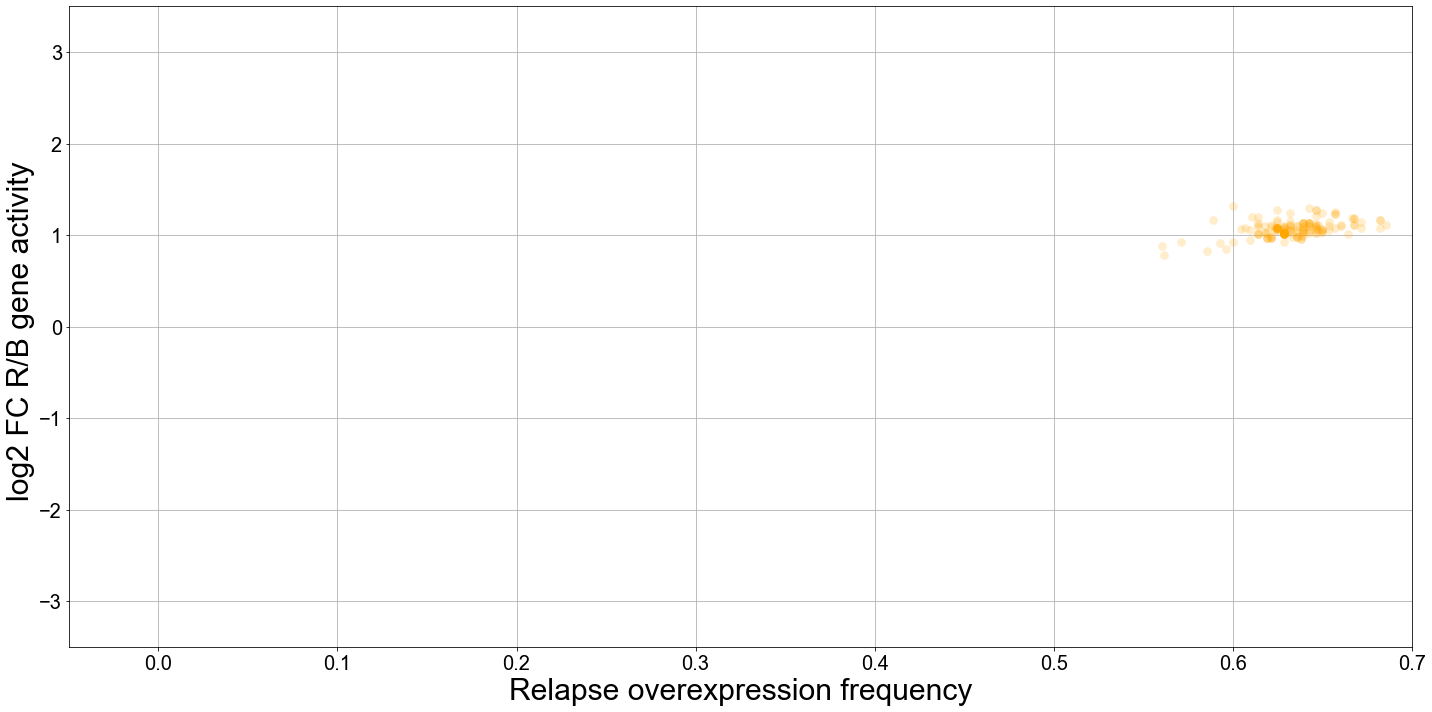

In [25]:
subset_patients = volcano_data.index[(volcano_data["-log10(p)"] > -numpy.log10(0.05)) & (volcano_data['log2(phenotype2/phenotype1)'] > 0.5) & (volcano_data['phenotype2_frequency'] > 0.55)]

subset_data = volcano_data.loc[subset_patients,:]

fig = matplotlib.pyplot.figure(figsize=(20,10))

matplotlib.pyplot.scatter(subset_data["phenotype2_frequency"],numpy.array(subset_data["log2(phenotype2/phenotype1)"]),color = 'orange',alpha=0.2,s=75,linewidths=0)

matplotlib.pyplot.xlim(-0.05,0.7)
matplotlib.pyplot.ylim(-3.5,3.5)
matplotlib.pyplot.ylabel("log2 FC R/B gene activity ")
matplotlib.pyplot.xlabel("Relapse overexpression frequency")
matplotlib.pyplot.grid()
matplotlib.pyplot.tight_layout()

In [26]:
subset_data.to_csv(path_or_buf='case_2.csv')

## 3.4 Find relapse signatures using matched patients of specific cytogenetics

In [27]:
baseline_patients=['MMRF_1783_1_BM','MMRF_1433_1_BM']
relapse_patients=['MMRF_1783_1_BM','MMRF_1433_2_BM','MMRF_1433_4_BM']
phenotype1 = baseline_patients
phenotype2 = relapse_patients

completed in 3.65 minutes
Error: Analysis was successful, but could not generate plot


,phenotype1_frequency,phenotype2_frequency,log2(phenotype2/phenotype1),-log10(p)
ENSG00000278759,1.0,0.333333,-1.584963,0.866343
ENSG00000198276,1.0,0.333333,-1.584963,0.866343
ENSG00000108861,1.0,0.333333,-1.584963,0.866343
ENSG00000100288,1.0,0.333333,-1.584963,0.866343
ENSG00000186908,1.0,0.333333,-1.584963,0.866343


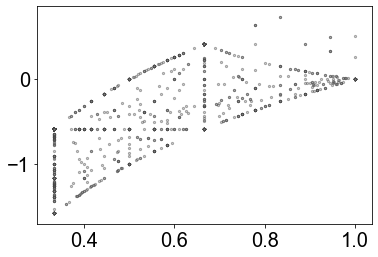

In [28]:
importlib.reload(miner)

volcano_data = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = 3,minRegulons = 3,useAllRegulons = True)
volcano_data.head()

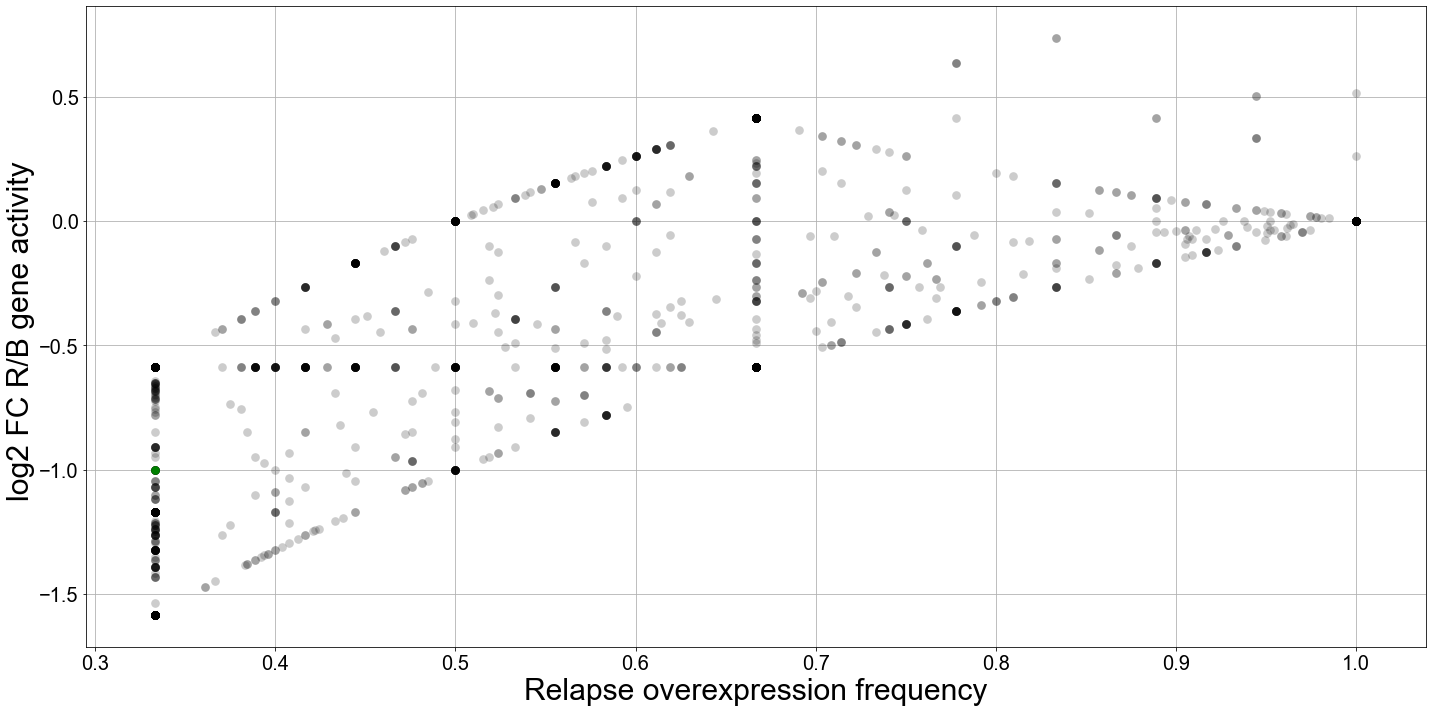

In [29]:
insigvoldata_patients = volcano_data.index[volcano_data["-log10(p)"]<=-numpy.log10(0.05)]
sigvoldata_patients_plus = volcano_data.index[(volcano_data["-log10(p)"] > -numpy.log10(0.05)) & (volcano_data['log2(phenotype2/phenotype1)'] > 0)]
sigvoldata_patients_minus = volcano_data.index[(volcano_data["-log10(p)"] > -numpy.log10(0.05)) & (volcano_data['log2(phenotype2/phenotype1)'] < 0)]

insigvoldata = volcano_data.loc[insigvoldata_patients,:]
sigvoldata_plus = volcano_data.loc[sigvoldata_patients_plus,:]
sigvoldata_minus = volcano_data.loc[sigvoldata_patients_minus,:]

fig = matplotlib.pyplot.figure(figsize=(20,10))

matplotlib.pyplot.scatter(sigvoldata_plus["phenotype2_frequency"],numpy.array(sigvoldata_plus["log2(phenotype2/phenotype1)"]),color = 'red',alpha=0.2,s=75,linewidths=0)

matplotlib.pyplot.scatter(sigvoldata_minus["phenotype2_frequency"],numpy.array(sigvoldata_minus["log2(phenotype2/phenotype1)"]),color = 'blue',alpha=0.2,s=100,linewidths=0)

matplotlib.pyplot.scatter(insigvoldata["phenotype2_frequency"],numpy.array(insigvoldata["log2(phenotype2/phenotype1)"]),color ='black',edgecolor = [0.1,0.1,0.1],alpha=0.2,s=75,linewidths=0)

matplotlib.pyplot.scatter(volcano_data.loc[ikzf1,"phenotype2_frequency"],numpy.array(volcano_data.loc[ikzf1,"log2(phenotype2/phenotype1)"]),color = 'green',s=75,linewidths=0)

#matplotlib.pyplot.xlim(-0.05,0.7)
#matplotlib.pyplot.ylim(-3.5,3.5)
matplotlib.pyplot.ylabel("log2 FC R/B gene activity ")
matplotlib.pyplot.xlabel("Relapse overexpression frequency")
matplotlib.pyplot.grid()
matplotlib.pyplot.tight_layout()

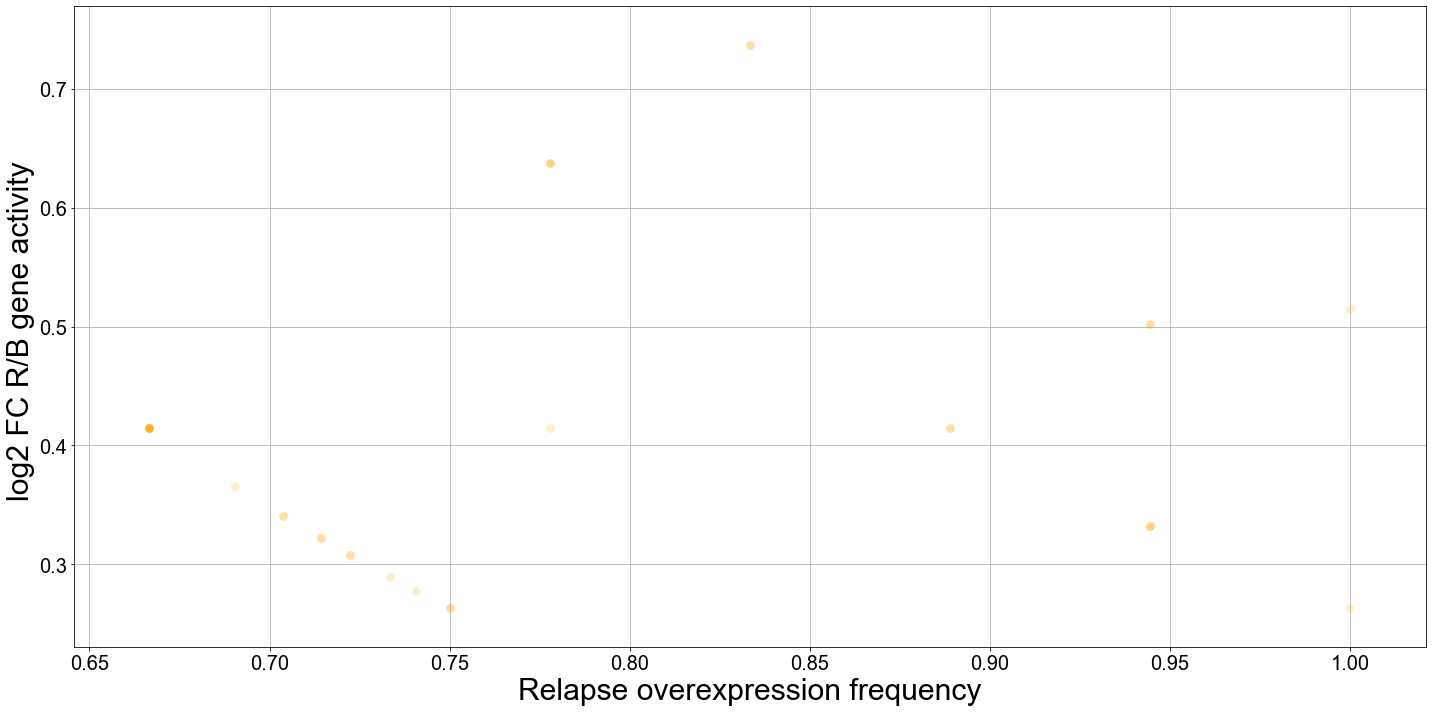

In [30]:
subset_patients = volcano_data.index[(volcano_data['log2(phenotype2/phenotype1)'] > 0.25) & (volcano_data['phenotype2_frequency'] > 2/3)]

subset_data = volcano_data.loc[subset_patients,:]

fig = matplotlib.pyplot.figure(figsize=(20,10))

matplotlib.pyplot.scatter(subset_data["phenotype2_frequency"],numpy.array(subset_data["log2(phenotype2/phenotype1)"]),color = 'orange',alpha=0.2,s=75,linewidths=0)

#matplotlib.pyplot.xlim(0.3,1.05)
#matplotlib.pyplot.ylim(-1.6,0.90)
matplotlib.pyplot.ylabel("log2 FC R/B gene activity ")
matplotlib.pyplot.xlabel("Relapse overexpression frequency")
matplotlib.pyplot.grid()
matplotlib.pyplot.tight_layout()

In [31]:
subset_data.to_csv(path_or_buf='case_3.csv')

In [32]:
# consider finding DETs in relapse, patient by patient with specific cytogenetics, then map to regulons

# 4. Map patients to states